# Anomaly Prediction in NEWT

In this Notebook, we revisit anomaly prediction by first looking at everything, then shrinking down: a "use all the data" approach.

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
import os
import pygam  # https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html
from pygam import LinearGAM, s, te, l, f
bp = "/scratch/dphilippus/notebooks/next_validation/"
weights = np.array([0.132, 0.401, 0.162, 0.119, 0.056, 0.13 ])  # see below.

# Anomaly Data Prep

In [2]:
data = pd.read_csv(bp + "DevData.csv", dtype={"id": "str"}, parse_dates=["date"])[["id", "date", "temperature", "tmax"]]
data = data[(data["temperature"] > -0.5) & (data["temperature"] < 40)]

In [7]:
data["day"] = data["date"].dt.day_of_year
dailies = data.groupby(["id", "day"])[["temperature", "tmax"]].mean().rename(columns={"temperature": "actemp"})

In [10]:
anom = data.merge(dailies, on=["id", "day"], suffixes=["", "_mean"])
anom["delta_st"] = anom["temperature"] - anom["actemp"]
anom["delta_at"] = anom["tmax"] - anom["tmax_mean"]
anom = anom[["id", "date", "day", "actemp", "delta_st", "delta_at"]].sort_values(["id", "date"])

# Lags

In [16]:
def addlags(grp, N=10):
    grp = grp.sort_values("date")
    for i in range(N):
        grp[f"delta{i}"] = grp["delta_at"].shift(i)
    return grp.dropna()
lanom = anom.groupby("id").apply(addlags, include_groups=False)

# Relationship Form Analysis

## Global

A global fit over 10 days gives a median R2 of 0.56, which is already better than the tailored fits from before.  Interestingly, there's always a slight spike in the coefficient on the last day, presumably capturing "previous weather".  Almost all of the performance is captured by using 6 days, though (median R2 = 0.55).

Note that that's R2, not bias, so we'd still need to estimate the sensitivity.  This is just a better smoother: 0.047, 0.142, 0.058, 0.042, 0.02 , 0.046 (for days 0-5).  However, that is the performance we get with a constant sensitivity.  Performance may be improved by smart sensitivity.

Normalized so the total effect is 1 C/C, standard weights are: `[0.132, 0.401, 0.162, 0.119, 0.056, 0.13 ]`.

In [118]:
X = lanom.loc[:, "delta0":"delta5"]
y = lanom["delta_st"]
sol = np.linalg.lstsq(X, y, rcond=None)[0]

In [119]:
np.round(sol, 3)

array([0.047, 0.142, 0.058, 0.042, 0.02 , 0.046])

In [120]:
np.round(sol/sum(sol), 3)

array([0.132, 0.401, 0.162, 0.119, 0.056, 0.13 ])

In [123]:
prd = X @ sol

In [124]:
comp = pd.DataFrame({"obs": y, "prd": prd})
comp.groupby("id").apply(lambda x: x["obs"].corr(x["prd"])**2).describe()

count    930.000000
mean       0.497391
std        0.209248
min        0.001009
25%        0.347728
50%        0.551483
75%        0.678223
max        0.820279
dtype: float64

## Sitewise

In [112]:
def solify(N=5, normalize=True, sensitivity=False, fit=False):
    def f(grp):
        X = grp.loc[:, "delta0":f"delta{N}"]
        y = grp["delta_st"]
        sol = np.linalg.lstsq(X, y, rcond=None)[0]
        if sensitivity:  # get total sensitivity
            return sum(sol)
        if fit:
            prd = X @ sol
            return prd.corr(y)**2
        if normalize:
            sol = sol/max(sol)
        return pd.DataFrame({"lag": range(N+1), "weight": sol})
    return f

In [105]:
weights = lanom.groupby("id").apply(solify(9, True))

Takeaways:

- Normalized: the highest weight is almost always (>75% of the time) on day 1, but days 0-6 generally have at least 10% weight.
- Not normalized: true weights usually vary by a factor of 2 or so in the IQR. Individual weights rarely exceed 0.2 C/C.
- Total sensitivity ranges up to 0.93 C/C (two sites have negative sensitivity), but 50% of the time is 0.3-0.55 C/C.
- The global weight is very similar to the median weight for all days.
- A site-specific fit outperforms the global fit by R2 + 0.03 (holds for 25th, 50th, 75th, max, and mean).  Obviously not worth it, so the normalized weights should be the global one.

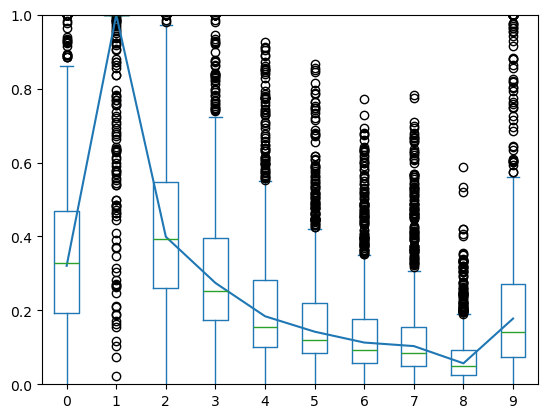

In [111]:
ax = weights.reset_index().pivot(index='id', columns='lag', values='weight').plot.box(ylim=(0, 1))
soln = sol / max(sol)
ax.plot(range(1, 11), soln)

In [113]:
lanom.groupby("id").apply(solify(9, False, True)).describe()

count    930.000000
mean       0.418204
std        0.167267
min       -0.284818
25%        0.307267
50%        0.427857
75%        0.546594
max        0.927061
dtype: float64

In [114]:
lanom.groupby("id").apply(solify(9, False, False, True)).describe()

count    930.000000
mean       0.539454
std        0.208162
min        0.001807
25%        0.397743
50%        0.596712
75%        0.712399
max        0.867945
dtype: float64

## Linearity

Is AT anomaly response linear over the full range?  Let's find out.  It's intractable to look at all the data together, so we're going to plot conditional quantiles.

The relationships do seem to be rather linear.  They flatten out around +7 C, but also get incredibly noisy, suggesting that the main issue is lack of data.

In [151]:
def prdweights(grp):
    grp = grp.sort_values("date")
    X = grp.loc[:, "delta0":"delta5"]
    y = grp["delta_st"]
    prd = X @ weights
    prd *= y.abs().mean() / prd.abs().mean()
    return pd.DataFrame({"obs": y, "prd": prd})

pw = lanom.groupby("id").apply(prdweights, include_groups=False).droplevel(1)

In [159]:
pw.describe()

,obs,prd
count,2.983556e+06,2.983556e+06
mean,-5.309735e-04,-1.504012e-03
std,1.803320e+00,1.791977e+00
min,-2.284489e+01,-1.513139e+01
25%,-1.032292e+00,-1.024828e+00
50%,-1.319444e-02,1.398353e-02
75%,1.028333e+00,1.049032e+00
max,1.393319e+01,1.472597e+01


In [169]:
def getqs(grp, size=0.1):
    qs = np.arange(size, 1, size)
    return pd.DataFrame({"quantile": qs.astype("str"), "value": grp["obs"].quantile(qs)})
pw["bucket"] = (pw["prd"] / 0.05).astype("int")
quants = pw.groupby("bucket").apply(getqs, include_groups=False).reset_index()
quants["bucket"] *= 0.05

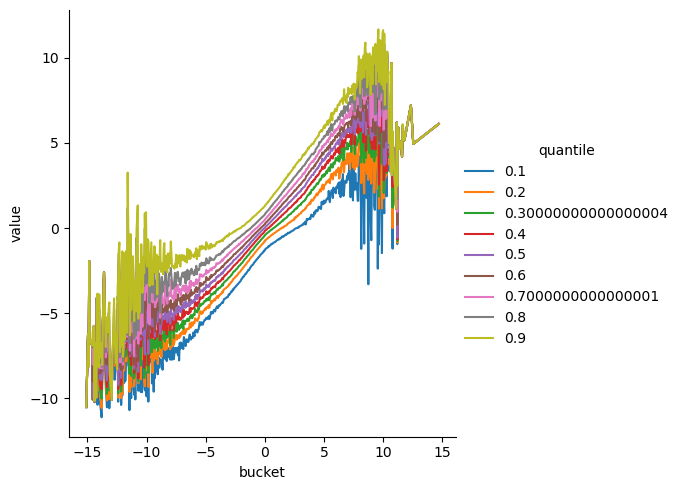

In [170]:
sns.relplot(x="bucket", y="value", hue="quantile", data=quants, kind="line")

## GAMmit?

Overall relationship is roughly linear.  How well can we do with a GAM bringing in interaction with the annual cycle?

Linear approach: global R2 0.50, median R2 0.55, RMSE 1.22 C, absolute bias 0.002 C.

Training the whole thing is intractable, so I'm using a random 10%.

With the first sample, we see a marginal improvement in global R2, to 0.52.  There's definitely a lumpy, nonlinear surface, but it doesn't seem to do that much.  This remained true (and the surface similar) over a couple more test runs.

With a direct comparison (trained on 10%, tested on everything), we get:

- Global R2: 0.52 (+0.02)
- Median R2: 0.60 (+0.05)
- Median RMSE: 1.12 C (-0.10 C)
- Median absolute bias: 0.01 C (+0.008 C)

So there is a non-trivial performance gain there, moreso for individual gages than globally.  Probably worth pursuing.  Note that the tensor interaction is important; it does not perform any better than the linear model with two non-interacting spline terms.

In [173]:
def prdweights(grp):
    grp = grp.sort_values("date")
    X = grp.loc[:, "delta0":"delta5"]
    y = grp["delta_st"]
    prd = X @ weights
    prd *= y.abs().mean() / prd.abs().mean()
    return pd.DataFrame({"date": grp["date"], "actemp": grp["actemp"], "obs": y, "prd": prd})

pw = lanom.groupby("id").apply(prdweights, include_groups=False).droplevel(1)

In [185]:
print(pw["obs"].corr(pw["prd"])**2)
print(pw.groupby("id").apply(lambda x: x["obs"].corr(x["prd"])**2).median())
print(pw.groupby("id").apply(lambda x: np.sqrt(((x["prd"] - x["obs"])**2).mean())).median())
print(pw.groupby("id").apply(lambda x: (x["prd"] - x["obs"]).mean()).abs().median())

0.49602259314756125
0.5515137092564077
1.2246261618754053
0.0022501420465526473


In [198]:
print(pw["obs"].corr(pw["gamprd"])**2)
print(pw.groupby("id").apply(lambda x: x["obs"].corr(x["gamprd"])**2).median())
print(pw.groupby("id").apply(lambda x: np.sqrt(((x["gamprd"] - x["obs"])**2).mean())).median())
print(pw.groupby("id").apply(lambda x: (x["gamprd"] - x["obs"]).mean()).abs().median())

0.5201954399589435
0.5953266628387985
1.1205545446128655
0.009625268863643451


In [201]:
pwt = pw.sample(frac=0.1)
X = pwt[["actemp", "prd"]]
y = pwt["obs"]
gam = LinearGAM(te(0, 1)).fit(X, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     39.8499
Link Function:                     IdentityLink Log Likelihood:                               -501773.5224
Number of Samples:                       298356 AIC:                                          1003628.7445
                                                AICc:                                          1003628.756
                                                GCV:                                                1.5551
                                                Scale:                                              1.5547
                                                Pseudo R-Squared:                                   0.5205
Feature Function                  Lam

/tmp/ipykernel_261925/395951340.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


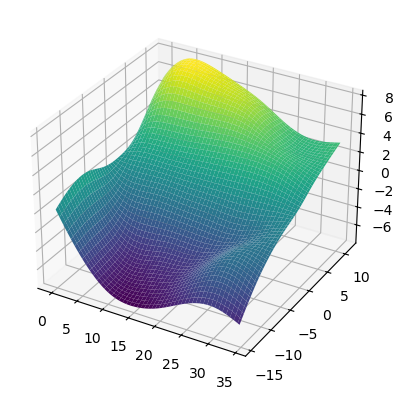

In [204]:
XX = gam.generate_X_grid(term=0, meshgrid=True)
Z = gam.partial_dependence(term=0, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')

In [197]:
pw["gamprd"] = gam.predict(pw[["actemp", "prd"]])

In [198]:
print(pw["obs"].corr(pw["gamprd"])**2)
print(pw.groupby("id").apply(lambda x: x["obs"].corr(x["gamprd"])**2).median())
print(pw.groupby("id").apply(lambda x: np.sqrt(((x["gamprd"] - x["obs"])**2).mean())).median())
print(pw.groupby("id").apply(lambda x: (x["gamprd"] - x["obs"]).mean()).abs().median())

0.5201954399589435
0.5953266628387985
1.1205545446128655
0.009625268863643451
